In [1]:
import os
import glob
import json
import face_recognition

import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1.  Example of using **face_recognition**

In [2]:
!ls '../dataset/actors/Adam Sandler'

Image_13.jpg  Image_2.jpg  Image_4.jpg	Image_6.jpg
Image_1.jpg   Image_3.jpg  Image_5.jpg	Image_9.jpg


In [68]:
image = face_recognition.load_image_file('../dataset/actors/Adam Sandler/Image_1.jpg')
face_locations = face_recognition.face_locations(image)

In [71]:
xy = (face_locations[0][3], face_locations[0][0])

width = face_locations[0][1] - face_locations[0][3]
height = face_locations[0][2] - face_locations[0][0]

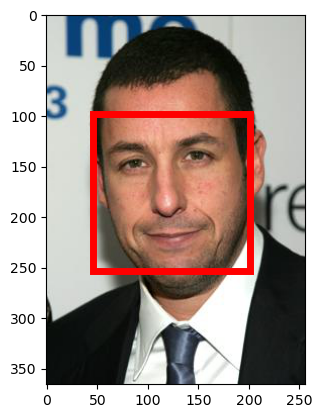

In [72]:
plt.imshow(image)

ax = plt.gca()
rect = patches.Rectangle(xy, width, height, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect);

# 2. Data preprocessing

In [36]:
with open('../config/actors.txt', 'r') as f:
    names = f.readlines()
names = names[:15]
labels_dict = {name[:-1]: i for i, name in enumerate(names)}

In [37]:
embeddings = np.empty(128)
target = []

for person in tqdm(list(labels_dict.keys())):
    n_files = len(glob.glob(f'../dataset/actors/{person}/*'))
    if n_files < 2:
        print(f'{person} is removed from dataset')
    else:
        images = os.listdir(f'../dataset/actors/{person}')
        n_images = len(images)

        for n, img in enumerate(images):
            try:
                if img != '.DS_Store':
                    face = face_recognition.load_image_file(f'../dataset/actors/{person}/{img}')
                    face_box = face_recognition.face_locations(face)

                    if len(face_box) == 1:
                        try:
                            face_embed = face_recognition.face_encodings(face)[0]
                            embeddings = np.vstack((embeddings, face_embed))
                            target.append(labels_dict[person])
                        
                        except Exception as ex:
                            print(f'Error message {ex}')

            except Exception as ex:
                print(f'Error message {ex}')
                
embeddings = embeddings[1:]

100%|██████████| 15/15 [00:53<00:00,  3.58s/it]


# 3. Model training

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, target, test_size=0.3, stratify=target, random_state=42)

In [39]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [40]:
f1 = f1_score(y_test, clf.predict(X_test), average='micro')
print(f'F1 score = {f1}')

F1 score = 0.7169811320754716


# 4. Model testing

In [81]:
def resize_image(SIZE, image):
    size = image.size

    coef = SIZE / size[0]
    resized_image = image.resize((int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    return res_image

In [82]:
SIZE = 1024

image = Image.open('../dataset/test/my_photo.jpg')
res_image = resize_image(SIZE, image)
res_image.save('../dataset/test/my_photo_resized.jpg')

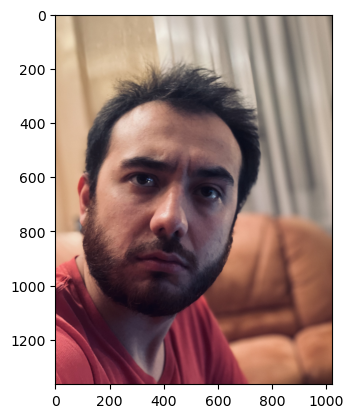

In [83]:
plt.imshow(res_image);

In [102]:
def predict_actor(path, clf, labels_dict):
    face = face_recognition.load_image_file(path)
    face_box = face_recognition.face_locations(face)

    if len(face_box) != 1:
        print('Problem with find face')
    else:
        face_embed = face_recognition.face_encodings(face)[0]

        predict = clf.predict([face_embed])
        predict_labels = list(labels_dict.keys())[list(labels_dict.values()).index(predict[0])]

        predict_proba = clf.predict_proba([face_embed])

        return predict_labels, predict_proba

In [142]:
predict_name, predict_proba = predict_actor('../dataset/test/my_photo_resized.jpg', clf, labels_dict)
predict_name

'Robert Downey Jr.'

In [143]:
df = pd.DataFrame()

df['act'] = list(labels_dict.keys())
df['score'] = predict_proba[0]

df.sort_values(by='score')[::-1]

,act,score
3,Robert Downey Jr.,0.098314
0,Dwayne Johnson,0.089016
7,Hugh Jackman,0.083264
1,Vin Diesel,0.072115
9,Henry Cavill,0.068818
11,Johnny Depp,0.066501
13,Tom Cruise,0.064614
8,Mark Wahlberg,0.064583
5,Ryan Reynolds,0.064544
6,Chris Pratt,0.063608


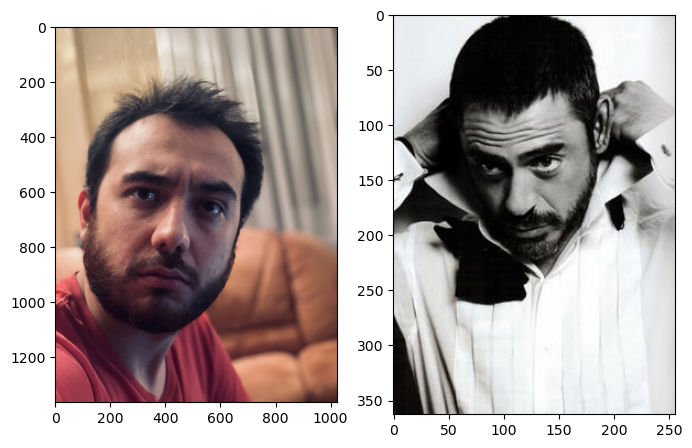

In [135]:
id_img = 11

image1 = face_recognition.load_image_file('../dataset/test/my_photo_resized.jpg')
image2 = face_recognition.load_image_file(f'../dataset/actors/{predict_name}/Image_{id_img}.jpg')

fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(image1);
ax[1].imshow(image2);

# 5. Cosine similarity estimation

In [136]:
def comparison(path, name, id_img):
    face_1 = face_recognition.load_image_file(path)
    face_embed_1 = face_recognition.face_encodings(face_1)[0]

    path_act = f'../dataset/actors/{name}/Image_{id_img}.jpg'

    face_2 = face_recognition.load_image_file(path_act)
    face_embed_2 = face_recognition.face_encodings(face_2)[0]

    return cosine_similarity(face_embed_1.reshape(1, -1), face_embed_2.reshape(1, -1))[0]

In [145]:
len_files = len(glob.glob(f'../dataset/actors/{predict_name}/*'))
cos = []

for i in tqdm(range(1, len_files + 1)):
    try:
        cos_ = comparison('../dataset/test/my_photo_resized.jpg', predict_name, i)
        cos.append(cos_)
    except Exception as ex:
        print(f'message: {ex}')

 29%|██▊       | 4/14 [00:06<00:16,  1.61s/it]

message: [Errno 2] No such file or directory: '../dataset/actors/Robert Downey Jr./Image_4.jpg'


100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


In [146]:
print(f'Mean cos sim score = {np.mean(cos)}')

Mean cos sim score = 0.8663519494133859
